# Upload data

## Import libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from tqdm.notebook import tqdm
from spacy.attrs import ORTH, NORM
from spacy.lang.en import English
from spacy.tokenizer import Tokenizer
from word_piece_tokenizer import WordPieceTokenizer
import spacy
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from pywaffle import Waffle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer

## A. Préparation de données

In [2]:
df = pd.read_csv("spooky.csv")
df.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


## B. Nettoyage d’un texte

### 1.Gérer les caractères répétitifs

In [3]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
repeating_char_pattern = re.compile(r"(\w*)(\w)\2(\w*)")
# \w* get a group of caracters
# (\w)\2 get in w one caracter and insure that is repeated
# \w* get the rest of caracters
replacement_pattern = r"\1\2\3"


def remove_repeating_chars(word):
    # Check if the word exists in WordNet
    if nltk.corpus.wordnet.synsets(word):
        return word
    # if not we reduce the repeated caracters
    replaced_word = repeating_char_pattern.sub(replacement_pattern, word)
    # if there is any change in the word then go again to check , else return as it is
    if replaced_word != word:
        return remove_repeating_chars(replaced_word)
    else:
        return replaced_word


def clean_text(text):
    words = text.split()
    cleaned_words = []
    for word in words:
        cleaned_words.append(remove_repeating_chars(word))
    cleaned_text = " ".join(cleaned_words)

    return cleaned_text

In [5]:
df['text'] = df['text'].apply(clean_text)
df

,id,text,author
0,id26305,"This proces, however, afforded me no means of ...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP
19575,id08973,The lids clenched themselves together as if in...,EAP
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP
19577,id17513,"For an item of news like this, it strikes us i...",EAP


#### Exemple to see how the result will be

In [6]:
data = {
    "text": ["cooooool story brooo", "sooo amaaaazing", "loooove this book hellloo"],
}

exemple = pd.DataFrame(data)
exemple["text"] = exemple["text"].apply(clean_text)
print(exemple)

                   text
0        cool story bro
1            so amazing
2  love this book hello


### 2.Manipuler des homoglyphes

In [7]:
homoglyph_map = {
    "a": [
        "а",
        "ɑ",
        "α",
        "@",
        "ӑ",
        "ȧ",
        "ǎ",
        "ạ",
        "ả",
        "a̤",
        "ḁ",
        "a̧",
        "ä",
        "å",
        "æ",
        "a̰",
        "a̱",
        "a̷",
        "а̰",
        "а̱",
        "а̷",
    ],
    "b": ["ƀ", "ƃ", "ɓ", "ƅ", "Ƅ", "ƅ", "β", "b̤", "b̥", "ḃ", "ḅ", "ḇ"],
    "c": ["ϲ", "с", "ç", "ć", "ĉ", "ċ", "č", "ĉ", "ç", "c̭"],
    "d": ["ԁ", "ď", "ḋ", "ḍ", "ḏ", "ḑ", "ḓ", "ď", "đ", "ƌ", "Ƌ", "ƌ", "ɖ"],
    "e": [
        "е",
        "є",
        "ё",
        "ē",
        "ĕ",
        "ė",
        "ę",
        "ě",
        "3",
        "ẹ",
        "ẻ",
        "è",
        "é",
        "ê",
        "ë",
        "ɇ",
        "ɛ",
        "ḛ",
        "e̱",
        "e̷",
        "э",
        "ɘ",
        "ɜ",
    ],
    "f": ["ƒ", "f̤", "f̥", "ḟ"],
    "g": ["ɡ", "ɠ", "ğ", "ǧ", "ģ", "ĝ", "g̈", "ğ", "ģ", "ġ"],
    "h": ["һ", "հ", "ɦ", "ħ", "ȟ", "ḣ", "ḥ", "ḧ", "ḩ", "ḫ", "ḧ", "h̄", "ḥ", "ẖ", "h̲"],
    "i": ["і", "ї", "1", "|", "!", "í", "ì", "ï", "ī", "ĭ", "į", "ỉ", "ị", "ɨ", "ɪ"],
    "j": ["ј", "ʝ", "ĵ", "ǰ", "ɉ", "ĵ", "ǰ", "j̇"],
    "k": ["κ", "к", "ƙ", "ķ", "ǩ", "ḳ", "ḵ", "k̄", "k̆", "k̇", "k̂"],
    "l": ["1", "|", "!", "1", "ɫ", "ɬ", "ɭ", "ĺ", "ļ", "ľ", "ŀ", "ḷ", "ḹ", "ḻ", "ḽ"],
    "m": ["ʍ", "ɯ", "ɰ", "ɱ", "м", "ṁ", "ṃ", "ṅ", "ṇ", "ṉ", "ṋ", "ṍ", "ṏ", "m̂"],
    "n": ["п", "ɴ", "ñ", "ń", "ņ", "ň", "ŉ", "ŋ", "n̂", "n̈", "ň", "n̄", "ṇ", "ṉ", "n̲"],
    "o": [
        "ο",
        "о",
        "0",
        "ȯ",
        "ọ",
        "ỏ",
        "ò",
        "ó",
        "ô",
        "õ",
        "ö",
        "ø",
        "ő",
        "ǒ",
        "ȍ",
        "ȫ",
        "ȭ",
        "ȯ",
        "ȱ",
        "o̤",
        "o̥",
        "o̧",
        "ö",
        "ơ",
        "ɵ",
    ],
    "p": ["ρ", "р", "ƥ", "ṕ", "ṗ", "p̤", "p̥"],
    "q": ["զ", "ʠ", "ɋ", "q̈", "q̧", "q̇", "q̣", "q̱"],
    "r": ["г", "ɾ", "ɼ", "ɽ", "ɾ", "ɿ", "ŕ", "ŗ", "ř", "ȑ", "ȓ", "ṙ", "ṛ", "ṝ", "ṟ"],
    "s": ["ѕ", "ѕ", "$", "ʂ", "ś", "ŝ", "ş", "š", "ș", "ŝ", "s̈", "ş", "ṡ", "ṣ"],
    "t": ["т", "τ", "ť", "ţ", "ț", "t̂", "ẗ", "ť", "ṫ", "ṭ"],
    "u": [
        "υ",
        "ս",
        "ʋ",
        "ư",
        "ǔ",
        "ǖ",
        "ǘ",
        "ǚ",
        "ǜ",
        "ụ",
        "ủ",
        "ứ",
        "ừ",
        "ử",
        "ữ",
        "ự",
        "ṳ",
        "u̥",
        "u̧",
        "ü",
    ],
    "v": ["ν", "ѵ", "v̇", "ṽ", "ṿ", "v̤", "v̥", "v̈", "v̄", "v̱", "v̲"],
    "w": [
        "ա",
        "ʍ",
        "ω",
        "ω",
        "ώ",
        "ŵ",
        "ẁ",
        "ẃ",
        "ẅ",
        "ẇ",
        "ẉ",
        "ẘ",
        "ŵ",
        "ẅ",
        "w̄",
        "w̆",
        "ẇ",
        "ẅ",
        "ẉ",
    ],
    "x": ["×", "х", "ẍ", "x̌"],
    "y": ["у", "γ", "ý", "ỳ", "ÿ", "ȳ", "ÿ", "ỵ", "ỷ", "ỹ", "ƴ", "ŷ", "ÿ", "y̱", "y̲"],
    "z": ["ʐ", "z", "ž", "ż", "ẑ", "ẓ", "ẕ"],
}

In [8]:
def manage_homoglyphs(text, homoglyph_map):
    cleaned_text = []
    for char in text:
        for base_char, homoglyphs in homoglyph_map.items():
            if char in homoglyphs:
                cleaned_text.append(base_char)
                break
        else:
            cleaned_text.append(char)
    return "".join(cleaned_text)


# Test the function
original_text = "$tupide"
converted_text = manage_homoglyphs(original_text, homoglyph_map)
print(converted_text)  # Output: "stupide"

stupide


In [9]:
dataset = ["$tupide", "h3llo", "w0rld", "h@f$@"]

# Clean the dataset
cleaned_dataset = [manage_homoglyphs(text,homoglyph_map) for text in dataset]
print(cleaned_dataset) 

['stupide', 'hello', 'world', 'hafsa']


In [10]:
def manage_homoglyphs_text(text):
    return manage_homoglyphs(text, homoglyph_map)

df["text"] = df["text"].apply(manage_homoglyphs_text)
df["text"]

0        This proces, however, afforded me no means of ...
1        It never once occurred to me that the fumbling...
2        In his left hand was a gold snuff box, from wh...
3        How lovely is spring As we looked from Windsor...
4        Finding nothing else, not even gold, the Super...
                               ...                        
19574    I could have fancied, while I looked at it, th...
19575    The lids clenched themselves together as if in...
19576    Mais il faut agir that is to say, a Frenchman ...
19577    For an item of news like this, it strikes us i...
19578    He laid a gnarled claw on my shoulder, and it ...
Name: text, Length: 19579, dtype: object

### 3.Transformer les entrée à une forme canonique

In [11]:
def transform_entree(text):
    text = re.sub(r"https?://\S+|www\.\S+", "[URL]", text)
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "[EMAIL]", text)
    text = BeautifulSoup(text, "html.parser").get_text()   
    return text

# Exemple:
text = "Visitez <b>mon site</b> : https://example.com ou envoyez-moi un email à contact@example.com"
cleaned_text = transform_entree(text)
print(cleaned_text)

Visitez mon site : [URL] ou envoyez-moi un email à [EMAIL]


In [12]:
df["text"] = df["text"].apply(transform_entree)

### 4.Mettre les caractères en minuscule

In [13]:
df["text"] = df["text"].str.lower()
df["text"].head(10)

0    this proces, however, afforded me no means of ...
1    it never once occurred to me that the fumbling...
2    in his left hand was a gold snuff box, from wh...
3    how lovely is spring as we looked from windsor...
4    finding nothing else, not even gold, the super...
5    a youth passed in solitude, my best years spen...
6    the astronomer, perhaps, at this point, took r...
7          the surcingle hung in ribands from my body.
8    i knew that you could not say to yourself 'ste...
9    i confess that neither the structure of langua...
Name: text, dtype: object

### 5.Supprimer la ponctuation 8.et les caracteres spéciaux

In [14]:
def remove_punctuation(text):
    tokens = word_tokenize(text)
    tokens_without_punctuation = [token for token in tokens if re.match(r'^[A-Za-z0-9]+$', token)] # all words must be only in caracters
    clean_text = ' '.join(tokens_without_punctuation)
    return clean_text

text = "This, is; an:example...sentence! It contains punctuation."
remove_punctuation(text)

'This is an example sentence It contains punctuation'

In [15]:
df["text"] = df["text"].apply(remove_punctuation)
df.head(10)

,id,text,author
0,id26305,this proces however afforded me no means of as...,EAP
1,id17569,it never once occurred to me that the fumbling...,HPL
2,id11008,in his left hand was a gold snuff box from whi...,EAP
3,id27763,how lovely is spring as we looked from windsor...,MWS
4,id12958,finding nothing else not even gold the superin...,HPL
5,id22965,a youth passed in solitude my best years spent...,MWS
6,id09674,the astronomer perhaps at this point took refu...,EAP
7,id13515,the surcingle hung in ribands from my body,EAP
8,id19322,i knew that you could not say to yourself with...,EAP
9,id00912,i confess that neither the structure of langua...,MWS


### 6.Supprimer les mots-vide

In [16]:
# remove stop words
stop = stopwords.words("english")
df["text"] = df["text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop)])
)
df["text"].head(10)

0    proces however afforded means ascertaining dim...
1           never occurred fumbling might mere mistake
2    left hand gold snuff box capered hil cutting m...
3    lovely spring looked windsor terrace sixteen f...
4    finding nothing else even gold superintendent ...
5    youth passed solitude best years spent gentle ...
6    astronomer perhaps point took refuge suggestio...
7                          surcingle hung ribands body
8    knew could say without brought think atomies t...
9    confess neither structure languages code gover...
Name: text, dtype: object

### 7.Détecter les langues

In [17]:
from langdetect import detect

data = {'text': ["Bonjour tout le monde", "hello everyone", "Guten Morgen", "hi my name is "]}
df_example = pd.DataFrame(data)

# Détecter les langues
langues_detectees_ex = df_example["text"].apply(detect)
print(langues_detectees_ex)


0    fr
1    en
2    de
3    sw
Name: text, dtype: object


In [18]:
from collections import Counter
def frequent_language(langues_detectees):
    return Counter(langues_detectees).most_common(1)[0][0]
    
frequent_language_ex = frequent_language(langues_detectees_ex)
print("Langue la plus fréquente :", frequent_language_ex)

Langue la plus fréquente : fr


####  traduire vers la langue la plus fréquente.

In [19]:
from googletrans import Translator

translator = Translator()
def translate_row(text, langue_frequente):
        return translator.translate(text, src=detect(text), dest=langue_frequente).text

df_example['text'] = df_example.apply(lambda row: translate_row(row['text'], frequent_language_ex), axis=1)

In [20]:
df_example['text']

0    Bonjour tout le monde
1           bonjour à tous
2                  Bonjour
3        Salut mon nom est
Name: text, dtype: object

#### Dans notre dataset

In [21]:
empty_texts = df[df['text'].str.strip().apply(lambda x: len(x) == 0)]
print(empty_texts)

           id text author
3601  id12242         EAP
6553  id26479         HPL


In [22]:
# delete empty text
df = df[df['text'].str.strip().apply(lambda x: len(x) > 0)]
empty_texts = df[df['text'].str.strip().apply(lambda x: len(x) == 0)]
print(empty_texts)

Empty DataFrame
Columns: [id, text, author]
Index: []


In [23]:
langues_detectees = df["text"].apply(detect)

In [24]:
langue_frequente = frequent_language(langues_detectees)
print("Langue la plus fréquente :", langue_frequente)

Langue la plus fréquente : en


In [25]:
df = df.copy()

In [26]:
from deep_translator import GoogleTranslator
from langdetect import detect

def translate_text_and_detect_language(text, frequent_language):
    try:
        detected_language = detect(text)  
        if detected_language != frequent_language and text.strip():
            translated_text = GoogleTranslator(source='auto', target=frequent_language).translate(text)
        else:
            translated_text = text  
        return detected_language, translated_text
    except Exception as e:
        print(f"Error translating text: {e}")
        return "error", text  

df['langues_detectee'], df['translated_text'] = zip(
    *df['text'].apply(lambda x: translate_text_and_detect_language(x, langue_frequente))
)

df.loc[:, 'langues_detectee'] = df['langues_detectee']
df.loc[:, 'translated_text'] = df['translated_text']

In [27]:
df

,id,text,author,langues_detectee,translated_text
0,id26305,proces however afforded means ascertaining dim...,EAP,en,proces however afforded means ascertaining dim...
1,id17569,never occurred fumbling might mere mistake,HPL,en,never occurred fumbling might mere mistake
2,id11008,left hand gold snuff box capered hil cutting m...,EAP,en,left hand gold snuff box capered hil cutting m...
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,en,lovely spring looked windsor terrace sixteen f...
4,id12958,finding nothing else even gold superintendent ...,HPL,en,finding nothing else even gold superintendent ...
...,...,...,...,...,...
19574,id17718,could fancied looked eminent landscape painter...,EAP,en,could fancied looked eminent landscape painter...
19575,id08973,lids clenched together spasm,EAP,en,lids clenched together spasm
19576,id05267,mais il faut agir say frenchman never faints o...,EAP,en,mais il faut agir say frenchman never faints o...
19577,id17513,item news like strikes us coolly received,EAP,en,item news like strikes us coolly received


### 9.Supprimer les répétitions de mots

In [28]:
def delete_repetition_words(text):
    mots = text.split()
    mots_sans_repetition = []
    [mots_sans_repetition.append(mot) for mot in mots if mot not in mots_sans_repetition]
    texte_sans_repetition = " ".join(mots_sans_repetition)
    return texte_sans_repetition

#exemple:
exemple = "Bonjour le le monde est est beau"
exemple = delete_repetition_words(exemple)
print(exemple)

Bonjour le monde est beau


In [29]:
df.loc[:, 'translated_text'] = df['translated_text'].apply(delete_repetition_words)
df

,id,text,author,langues_detectee,translated_text
0,id26305,proces however afforded means ascertaining dim...,EAP,en,proces however afforded means ascertaining dim...
1,id17569,never occurred fumbling might mere mistake,HPL,en,never occurred fumbling might mere mistake
2,id11008,left hand gold snuff box capered hil cutting m...,EAP,en,left hand gold snuff box capered hil cutting m...
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,en,lovely spring looked windsor terrace sixteen f...
4,id12958,finding nothing else even gold superintendent ...,HPL,en,finding nothing else even gold superintendent ...
...,...,...,...,...,...
19574,id17718,could fancied looked eminent landscape painter...,EAP,en,could fancied looked eminent landscape painter...
19575,id08973,lids clenched together spasm,EAP,en,lids clenched together spasm
19576,id05267,mais il faut agir say frenchman never faints o...,EAP,en,mais il faut agir say frenchman never faints o...
19577,id17513,item news like strikes us coolly received,EAP,en,item news like strikes us coolly received


In [30]:
df = df.copy()
df['text'] = df['translated_text']  
df_cleaned = df[['id', 'text', 'author']]
df_cleaned

,id,text,author
0,id26305,proces however afforded means ascertaining dim...,EAP
1,id17569,never occurred fumbling might mere mistake,HPL
2,id11008,left hand gold snuff box capered hil cutting m...,EAP
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS
4,id12958,finding nothing else even gold superintendent ...,HPL
...,...,...,...
19574,id17718,could fancied looked eminent landscape painter...,EAP
19575,id08973,lids clenched together spasm,EAP
19576,id05267,mais il faut agir say frenchman never faints o...,EAP
19577,id17513,item news like strikes us coolly received,EAP


## C. Segmentation

### 1.Segmenter chaque phrase sur les espaces / la ponctuation

In [31]:
df_cleaned = df_cleaned.copy()
df_cleaned["space_tokenized_text"] = df_cleaned["text"].apply(lambda x: word_tokenize(x))
df_cleaned["space_tokenized_text"].head(10)

0    [proces, however, afforded, means, ascertainin...
1    [never, occurred, fumbling, might, mere, mistake]
2    [left, hand, gold, snuff, box, capered, hil, c...
3    [lovely, spring, looked, windsor, terrace, six...
4    [finding, nothing, else, even, gold, superinte...
5    [youth, passed, solitude, best, years, spent, ...
6    [astronomer, perhaps, point, took, refuge, sug...
7                     [surcingle, hung, ribands, body]
8    [knew, could, say, without, brought, think, at...
9    [confess, neither, structure, languages, code,...
Name: space_tokenized_text, dtype: object

### 2. Segmenter chaque phrase avec un algorithme de segmentation basé sur des règles

In [32]:
tqdm.pandas()

# ORTH = original text form, NORM = meaningful form.
special_cases = {
    "can't": [{"ORTH": "ca", "NORM": "can"}, {"ORTH": "n't", "NORM": "not"}],
    "don't": [{"ORTH": "do"}, {"ORTH": "n't", "NORM": "not"}],
    "wanna": [{"ORTH": "wan", "NORM": "want"}, {"ORTH": "na", "NORM": "to"}],
    "gonna": [{"ORTH": "gon", "NORM": "going"}, {"ORTH": "na", "NORM": "to"}],
    "she's": [{"ORTH": "she"}, {"ORTH": "'s", "NORM": "is"}],
    "he's": [{"ORTH": "he"}, {"ORTH": "'s", "NORM": "is"}],
    "it's": [{"ORTH": "it"}, {"ORTH": "'s", "NORM": "is"}],
    "I'm": [{"ORTH": "I"}, {"ORTH": "'m", "NORM": "am"}],
    "they're": [{"ORTH": "they"}, {"ORTH": "'re", "NORM": "are"}]
}

nlp = English()
tokenizer = nlp.tokenizer

for text, tokens in special_cases.items():
    tokenizer.add_special_case(text, tokens)

def rule_based_tokenize(text):
    return [t.norm_ for t in tokenizer(text)]

df_cleaned["rule_tokenized_text"] = df_cleaned["text"].progress_apply(rule_based_tokenize)
# keep only unique tokens
rule_vocab = set(token for sublist in df_cleaned["rule_tokenized_text"] for token in sublist)

  0%|          | 0/19577 [00:00<?, ?it/s]

In [33]:
df_cleaned

,id,text,author,space_tokenized_text,rule_tokenized_text
0,id26305,proces however afforded means ascertaining dim...,EAP,"[proces, however, afforded, means, ascertainin...","[proces, however, afforded, means, ascertainin..."
1,id17569,never occurred fumbling might mere mistake,HPL,"[never, occurred, fumbling, might, mere, mistake]","[never, occurred, fumbling, might, mere, mistake]"
2,id11008,left hand gold snuff box capered hil cutting m...,EAP,"[left, hand, gold, snuff, box, capered, hil, c...","[left, hand, gold, snuff, box, capered, hil, c..."
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,"[lovely, spring, looked, windsor, terrace, six...","[lovely, spring, looked, windsor, terrace, six..."
4,id12958,finding nothing else even gold superintendent ...,HPL,"[finding, nothing, else, even, gold, superinte...","[finding, nothing, else, even, gold, superinte..."
...,...,...,...,...,...
19574,id17718,could fancied looked eminent landscape painter...,EAP,"[could, fancied, looked, eminent, landscape, p...","[could, fancied, looked, eminent, landscape, p..."
19575,id08973,lids clenched together spasm,EAP,"[lids, clenched, together, spasm]","[lids, clenched, together, spasm]"
19576,id05267,mais il faut agir say frenchman never faints o...,EAP,"[mais, il, faut, agir, say, frenchman, never, ...","[mais, il, faut, agir, say, frenchman, never, ..."
19577,id17513,item news like strikes us coolly received,EAP,"[item, news, like, strikes, us, coolly, received]","[item, news, like, strikes, us, coolly, received]"


### 3.Segmenter chaque phrase avec un algorithme de segmentation en sous mots

In [34]:
word_piece_tokenizer = WordPieceTokenizer()
def wordpiece(text):
    ids = word_piece_tokenizer.tokenize(text)
    return word_piece_tokenizer.convert_ids_to_tokens(ids)

subword_vocab = []
df_cleaned["wordpiece_tokenized_text"] = df_cleaned["text"].progress_apply(wordpiece)
for tokens in df_cleaned["wordpiece_tokenized_text"]:
    subword_vocab.extend(tokens)

subword_vocab = set(subword_vocab)

  0%|          | 0/19577 [00:00<?, ?it/s]

In [35]:
df_cleaned

,id,text,author,space_tokenized_text,rule_tokenized_text,wordpiece_tokenized_text
0,id26305,proces however afforded means ascertaining dim...,EAP,"[proces, however, afforded, means, ascertainin...","[proces, however, afforded, means, ascertainin...","[[CLS], pro, ##ces, however, afforded, means, ..."
1,id17569,never occurred fumbling might mere mistake,HPL,"[never, occurred, fumbling, might, mere, mistake]","[never, occurred, fumbling, might, mere, mistake]","[[CLS], never, occurred, fu, ##mbling, might, ..."
2,id11008,left hand gold snuff box capered hil cutting m...,EAP,"[left, hand, gold, snuff, box, capered, hil, c...","[left, hand, gold, snuff, box, capered, hil, c...","[[CLS], left, hand, gold, s, ##nu, ##ff, box, ..."
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,"[lovely, spring, looked, windsor, terrace, six...","[lovely, spring, looked, windsor, terrace, six...","[[CLS], lovely, spring, looked, windsor, terra..."
4,id12958,finding nothing else even gold superintendent ...,HPL,"[finding, nothing, else, even, gold, superinte...","[finding, nothing, else, even, gold, superinte...","[[CLS], finding, nothing, else, even, gold, su..."
...,...,...,...,...,...,...
19574,id17718,could fancied looked eminent landscape painter...,EAP,"[could, fancied, looked, eminent, landscape, p...","[could, fancied, looked, eminent, landscape, p...","[[CLS], could, fan, ##cie, ##d, looked, eminen..."
19575,id08973,lids clenched together spasm,EAP,"[lids, clenched, together, spasm]","[lids, clenched, together, spasm]","[[CLS], lids, clenched, together, spa, ##sm, [..."
19576,id05267,mais il faut agir say frenchman never faints o...,EAP,"[mais, il, faut, agir, say, frenchman, never, ...","[mais, il, faut, agir, say, frenchman, never, ...","[[CLS], mai, ##s, il, fa, ##ut, ag, ##ir, say,..."
19577,id17513,item news like strikes us coolly received,EAP,"[item, news, like, strikes, us, coolly, received]","[item, news, like, strikes, us, coolly, received]","[[CLS], item, news, like, strikes, us, cool, #..."


In [36]:
df_cleaned.to_csv('spooky_cleaned.csv', index=False)  

## D. Reconnaissance d'entité nommée

In [37]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [38]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Sample sentences
sentences = df_cleaned["text"].head(10)

for sent in sentences:
    doc = nlp(sent)
    
    # Named Entity Recognition
    print(f"Sentence: {sent}")
    print("Named Entities:")
    for ent in doc.ents:
        print(f"  {ent.text} ({ent.label_})")
    
    # POS Tagging
    print("\nPOS Tags:")
    for token in doc:
        print(f"  {token.text}: {token.pos_} ({spacy.explain(token.pos_)})")
    
    print("\n" + "-"*50 + "\n")

Sentence: proces however afforded means ascertaining dimensions dungeon might make circuit return point whence set without aware fact perfectly uniform seemed wal
Named Entities:
  wal (ORG)

POS Tags:
  proces: NOUN (noun)
  however: ADV (adverb)
  afforded: VERB (verb)
  means: NOUN (noun)
  ascertaining: VERB (verb)
  dimensions: NOUN (noun)
  dungeon: NOUN (noun)
  might: AUX (auxiliary)
  make: VERB (verb)
  circuit: NOUN (noun)
  return: NOUN (noun)
  point: NOUN (noun)
  whence: NOUN (noun)
  set: VERB (verb)
  without: ADP (adposition)
  aware: ADJ (adjective)
  fact: NOUN (noun)
  perfectly: ADV (adverb)
  uniform: ADJ (adjective)
  seemed: VERB (verb)
  wal: NOUN (noun)

--------------------------------------------------

Sentence: never occurred fumbling might mere mistake
Named Entities:

POS Tags:
  never: ADV (adverb)
  occurred: VERB (verb)
  fumbling: VERB (verb)
  might: AUX (auxiliary)
  mere: VERB (verb)
  mistake: NOUN (noun)

---------------------------------------

## E. Réduction des formes

In [39]:
stemmer = SnowballStemmer(language="english")
df_cleaned["stemmed_text"] = df_cleaned["text"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
df_cleaned["stemmed_text"].head(10)

0    proce howev afford mean ascertain dimens dunge...
1                  never occur fumbl might mere mistak
2    left hand gold snuff box caper hil cut manner ...
3    love spring look windsor terrac sixteen fertil...
4    find noth els even gold superintend abandon at...
5    youth pass solitud best year spent gentl femin...
6    astronom perhap point took refug suggest non l...
7                            surcingl hung riband bodi
8    knew could say without brought think atomi thu...
9    confess neither structur languag code govern p...
Name: stemmed_text, dtype: object

## F. Analyse des fréquences

### 1. Compter le nombre de phrases, pour chaque auteur, où apparaît le mot Great.

In [40]:
authorByText = df_cleaned[["text","author"]].groupby(by="author").agg(' '.join) # we get for each row(author) his all text
cv = CountVectorizer().fit(authorByText["text"]) # convert text for each author to bag of words
counts = cv.transform(authorByText["text"]) # convert it then to matrix where each col represent a word
counted_text = pd.DataFrame(data=counts.toarray(),index=authorByText.index,columns=cv.get_feature_names_out())
counted_text

,ab,aback,abaft,abandon,abandoned,abandoning,abandonment,abaout,abased,abasement,...,zodiac,zodiacal,zoilus,zokar,zone,zones,zopyrus,zory,zubmizion,zuro
author,,,,,,,,,,,,,,,,,,,,,
EAP,1,2,0,7,11,2,2,0,1,1,...,1,2,1,0,1,1,1,1,1,0
HPL,0,0,0,3,13,1,0,20,0,0,...,0,0,0,3,1,0,0,0,0,1
MWS,0,0,1,1,5,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
counted_text["great"]

author
EAP    212
HPL    179
MWS     85
Name: great, dtype: int64

### 2.Utiliser pywaffle pour obtenir un graphique qui résume de manière synthétique le nombre d’occurrences du mot “great ” par auteur.

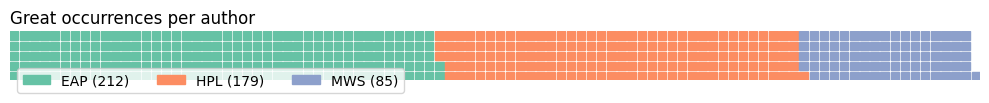

In [42]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=counted_text["great"],
    title={"label": "Great occurrences per author", "loc": "left"},
    labels=[f"{k} ({v})" for k, v in counted_text["great"].items()],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.4), "ncol": len(counted_text["great"])},
    figsize=(10, 5),
)

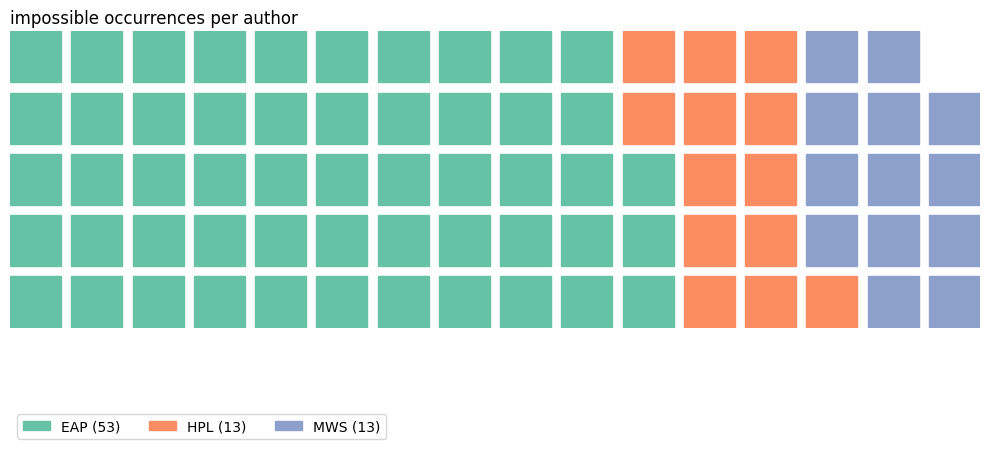

In [43]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=counted_text["impossible"],
    title={"label": "impossible occurrences per author", "loc": "left"},
    labels=[f"{k} ({v})" for k, v in counted_text["impossible"].items()],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.4), "ncol": len(counted_text["impossible"])},
    figsize=(10, 5),
)

### 4.En utilisant la fonction wordCloud, faire trois nuages de mots pour représenter les mots les plus utilisés par chaque auteur

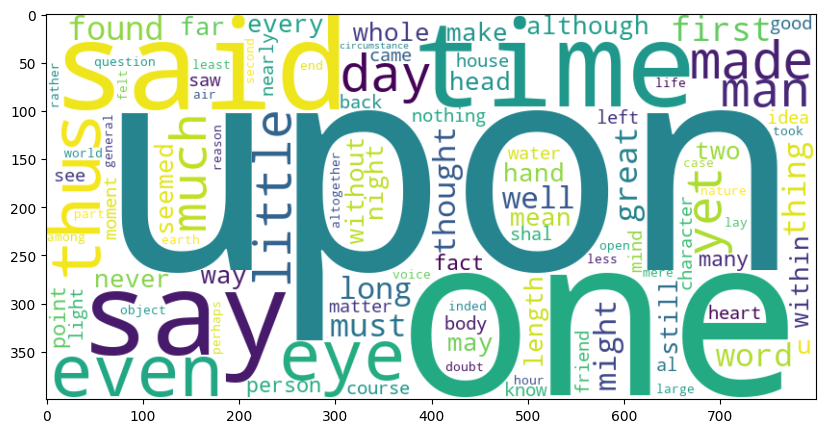

In [44]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(authorByText["text"]["EAP"])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")

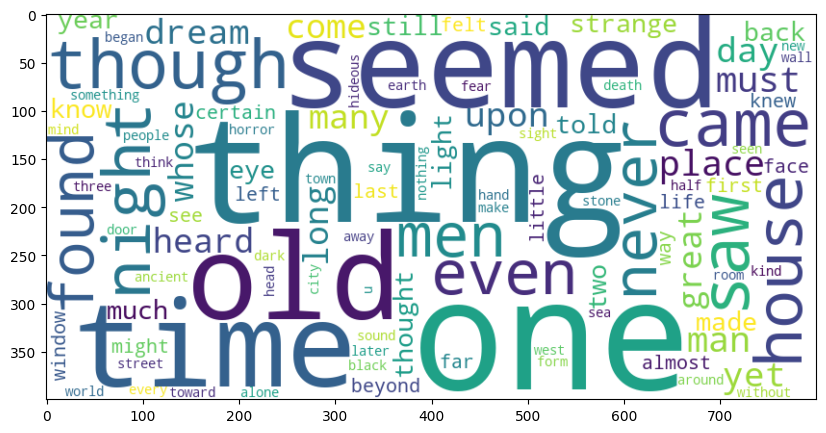

In [45]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(authorByText["text"]["HPL"])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")

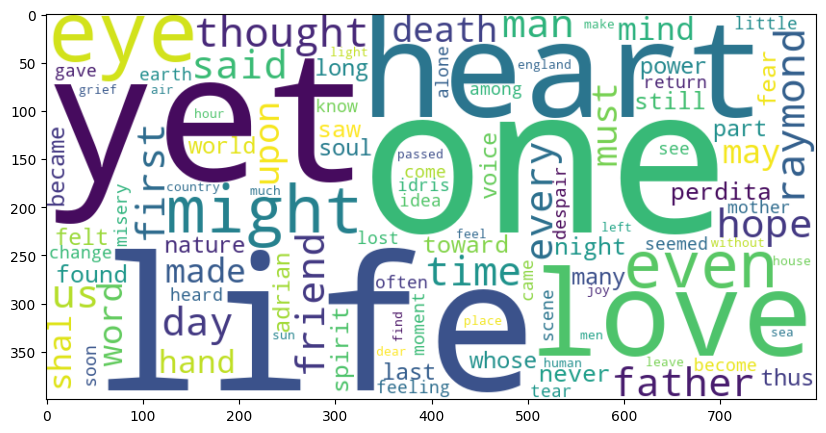

In [46]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(authorByText["text"]["MWS"])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")

### 5. En utilisant la fonction wordCloud, montrer les 100 meilleurs mots positifs et négatifs utilisés par les auteurs.

In [47]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hafsa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

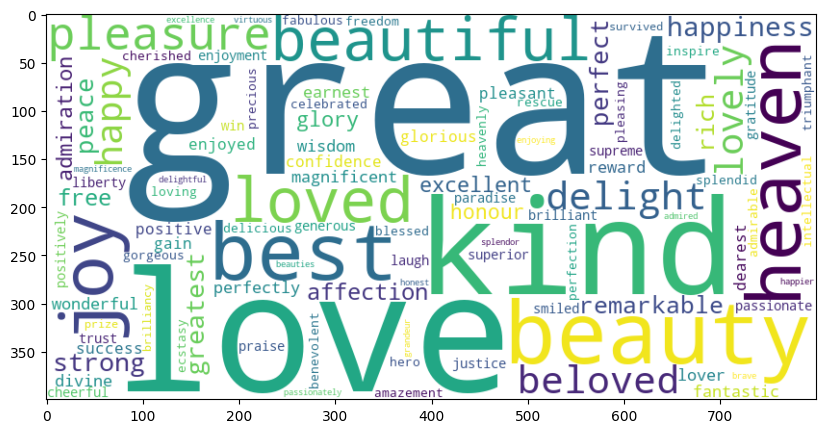

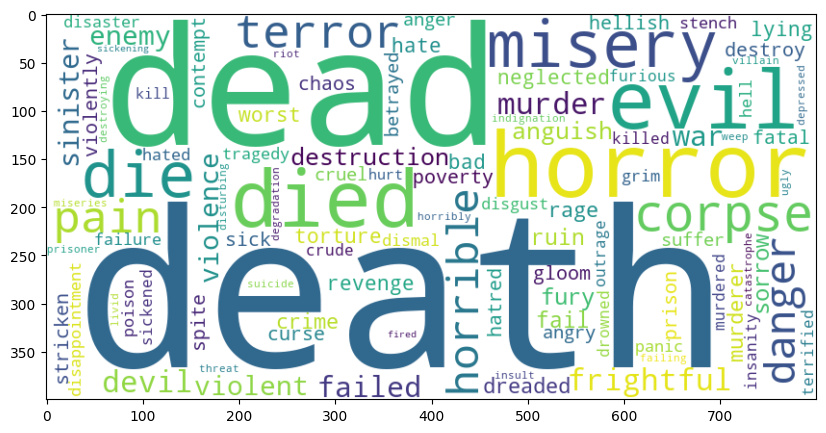

In [48]:
sid = SentimentIntensityAnalyzer()
positive_words = []
negative_words = []
for author in authorByText.index:
    for word in authorByText["text"][author].split():
        if sid.polarity_scores(word)["compound"] > 0.5:
            positive_words.append(word)
        elif sid.polarity_scores(word)["compound"] < -0.5:
            negative_words.append(word)

positive_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(" ".join(positive_words))
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation="bilinear")

negative_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(" ".join(negative_words))
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation="bilinear")

### 6. Identifier la polarité la plus fréquente pour chaque auteur (analyse de sentiment).

In [49]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Initialisation de l'analyseur de sentiments
sid = SentimentIntensityAnalyzer()

# Calcul des scores de sentiment pour chaque texte
def calculate_sentiment(text):
    score = sid.polarity_scores(text)
    if score["compound"] >= 0.05:
        return "positive"
    elif score["compound"] <= -0.05:
        return "negative"
    else:
        return "neutral"

# Ajouter une colonne "sentiment" au DataFrame
df_cleaned["sentiment"] = df_cleaned["text"].apply(calculate_sentiment)


In [50]:
# Regrouper par auteur et trouver la polarité la plus fréquente
dominant_sentiment = (
    df_cleaned.groupby("author")["sentiment"]
    .apply(lambda x: x.value_counts().idxmax())
    .reset_index(name="dominant_sentiment")
)

print(dominant_sentiment)


  author dominant_sentiment
0    EAP           positive
1    HPL           negative
2    MWS           positive
